In [82]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pickle
import numpy as np
import pandas as pd
import os
import base64
import string
import nltk
import re
from html.parser import HTMLParser 
import gensim
import glob as glob
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation
from nltk.tokenize import word_tokenize
import base64
import numpy as np
import pandas as pd
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from collections import Counter
from scipy.misc import imread
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from matplotlib import pyplot as plt
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss,f1_score
import xgboost as xgb
from xgboost import XGBClassifier

In [51]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test_nvPHrOx.csv")

train.head()
train.shape
train.info()
train.Tag.value_counts()

test.head()
test.shape
test.info()
test.Tag.value_counts()

df =  train.append(test)
df['Tag'].isnull().sum()
df.Tag.value_counts()

,Webpage_id,Domain,Url,Tag
0,1,www.fiercepharma.com,http://www.fiercepharma.com/marketing/tecfidera-gilenya-and-aubagio-s-3-way-battle-for-ms-share-about-to-get-more-interesting,news
1,2,www.fiercepharma.com,http://www.fiercepharma.com/pharma/novo-equipped-to-weather-storm-u-s-diabetes-market-ceo-says,news
2,3,www.fiercepharma.com,http://www.fiercepharma.com/pharma/another-exec-departs-troubled-endo-and-time-it-s-for-another-drugmaker,news
3,4,www.fiercepharma.com,http://www.fiercepharma.com/pharma/teva-buy-biosim-specialist-celltrion-it-wouldn-t-say-no,news
4,5,www.fiercepharma.com,http://www.fiercepharma.com/marketing/actress-marissa-tomei-partners-allergan-restasis-to-drive-dry-eye-awareness,news


(53447, 4)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53447 entries, 0 to 53446
Data columns (total 4 columns):
Webpage_id    53447 non-null int64
Domain        53447 non-null object
Url           53447 non-null object
Tag           53447 non-null object
dtypes: int64(1), object(3)
memory usage: 1.6+ MB


others            17417
news               7992
publication        7705
profile            5196
conferences        4666
forum              4503
clinicalTrials     2839
thesis             1800
guidelines         1329
Name: Tag, dtype: int64

,Webpage_id,Domain,Url,Tag
0,31,isrctn.com,http://www.isrctn.com/ISRCTN57801413,NaN
1,32,www.clinicaltrialsregister.eu,https://www.clinicaltrialsregister.eu/ctr-search/trial/2006-006214-16/GB,NaN
2,33,www.clinicaltrialsregister.eu,https://www.clinicaltrialsregister.eu/ctr-search/trial/2006-004265-34/LT,NaN
3,34,www.clinicaltrialsregister.eu,https://www.clinicaltrialsregister.eu/ctr-search/trial/2010-022183-12/IT,NaN
4,35,www.clinicaltrialsregister.eu,https://www.clinicaltrialsregister.eu/ctr-search/trial/2010-021349-36/NL,NaN


(25787, 4)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25787 entries, 0 to 25786
Data columns (total 4 columns):
Webpage_id    25787 non-null int64
Domain        25787 non-null object
Url           25787 non-null object
Tag           0 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 805.9+ KB


Series([], Name: Tag, dtype: int64)

25787

others            17417
news               7992
publication        7705
profile            5196
conferences        4666
forum              4503
clinicalTrials     2839
thesis             1800
guidelines         1329
Name: Tag, dtype: int64

In [52]:
## replace double space with single space
## converting to lower case
## keep only non-numeric 
## replace mispelled spelling with correct ones (iterative)
## tokenezied the notes (after processing above steps)
## remove the stopwords (iterative)
## lemmatization
53447+25787
df.shape

79234

(79234, 4)

In [53]:


## stopword list
stopword_list = set(stopwords.words('english')+list(punctuation))
stopword_list.update(['http','com','www'])

## misspell dictionary
my_dict = {'accommodate':'accommodate',
'accommodated':'accommodate',
'accommodating':'accommodate',

}



In [54]:

## defined functions

def spell_check(st): 
    words = st.split()
    tt=' '.join(str(my_dict.get(word, word)) for word in words)
    return(tt) 


lemma = WordNetLemmatizer()
def split_into_lemmas(notes):
    #notes=notes.lower()
    words=word_tokenize(notes)
    words_without_stop=[]
    for word in words:
        if word in stopword_list:continue
        elif len(word) in (1,2):continue
        words_without_stop.append(word)
    
    return[lemma.lemmatize(word) for word in words_without_stop]


In [55]:
## replace double space with single space
df['Url'] = df['Url'].apply(lambda x: re.sub('\s{2,}',' ',x)) 
## converting to lower case
df['Url'] = df['Url'].str.lower()
## keep only non-numeric figures
df['Url'] = df['Url'].apply(lambda x: re.sub('[^a-z]+',' ',x)) ## removes all numbers

## replace mispelled spelling with correct ones (iterative)
df['Url'] = df['Url'].apply(spell_check)
## tokenezied the notes (after processing above steps)
## remove the stopwords (iterative)
## lemmatization
word_corpus = df['Url'].apply(split_into_lemmas)

In [56]:
word_corpus[1:4]

1          [fiercepharma, pharma, novo, equipped, weather, storm, diabetes, market, ceo, say]
2    [fiercepharma, pharma, another, exec, departs, troubled, endo, time, another, drugmaker]
3                       [fiercepharma, pharma, teva, buy, biosim, specialist, celltrion, say]
Name: Url, dtype: object

In [57]:
#word_corpus[1]
#flatten the lists
flattened_list = [y for x in word_corpus for y in x]
k = pd.DataFrame(flattened_list,columns=['words'])
k['words'].value_counts().to_csv('words_clean_1.csv')


In [58]:
word_corpus.shape

(79234,)

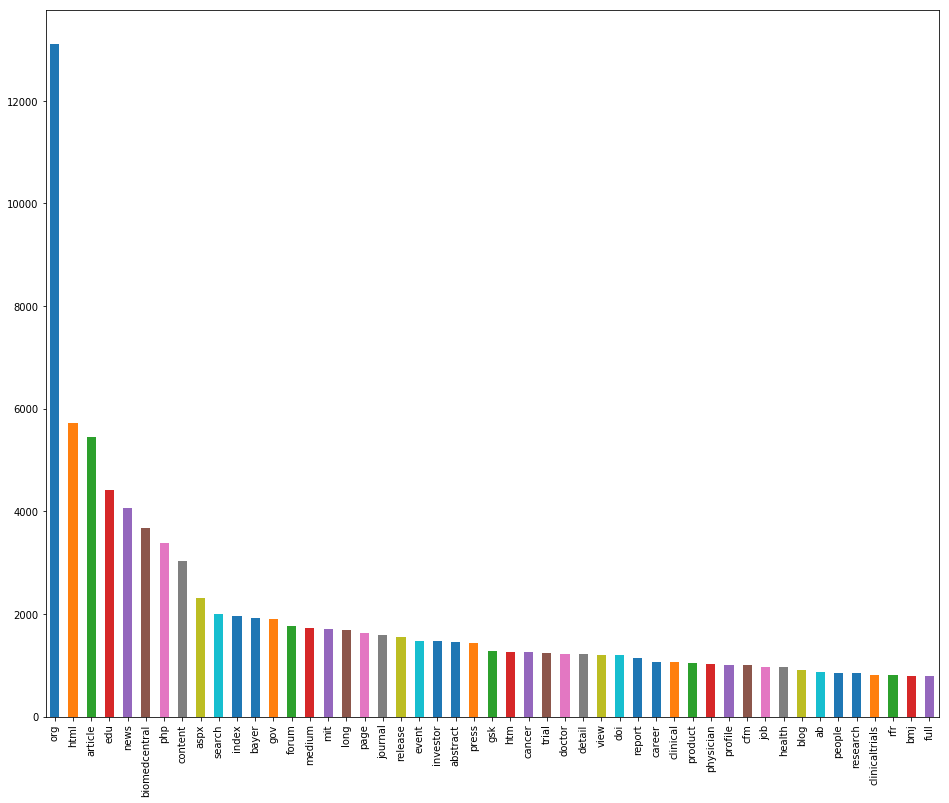

In [34]:
## top words
plt.figure(figsize=(16,13))
k['words'].value_counts()[1:50].plot(kind='bar')


In [36]:
others = word_corpus[df.Tag=='others'].apply(lambda x:' '.join(x))
news = word_corpus[df.Tag=='news'].apply(lambda x:' '.join(x))
publication = word_corpus[df.Tag=='publication'].apply(lambda x:' '.join(x))
profile = word_corpus[df.Tag=='profile'].apply(lambda x:' '.join(x))
conferences = word_corpus[df.Tag=='conferences'].apply(lambda x:' '.join(x))
forum = word_corpus[df.Tag=='forum'].apply(lambda x:' '.join(x))
clinicalTrials = word_corpus[df.Tag=='clinicalTrials'].apply(lambda x:' '.join(x))
thesis = word_corpus[df.Tag=='thesis'].apply(lambda x:' '.join(x))
guidelines = word_corpus[df.Tag=='guidelines'].apply(lambda x:' '.join(x))

others.shape,news.shape,publication.shape
profile.shape,conferences.shape,forum.shape
clinicalTrials.shape, thesis.shape,guidelines.shape

((17417,), (7992,), (7705,))

((5196,), (4666,), (4503,))

((2839,), (1800,), (1329,))

Text(0.5,1,'GUIDELINES WORD CLOUD')

(-0.5, 399.5, 199.5, -0.5)

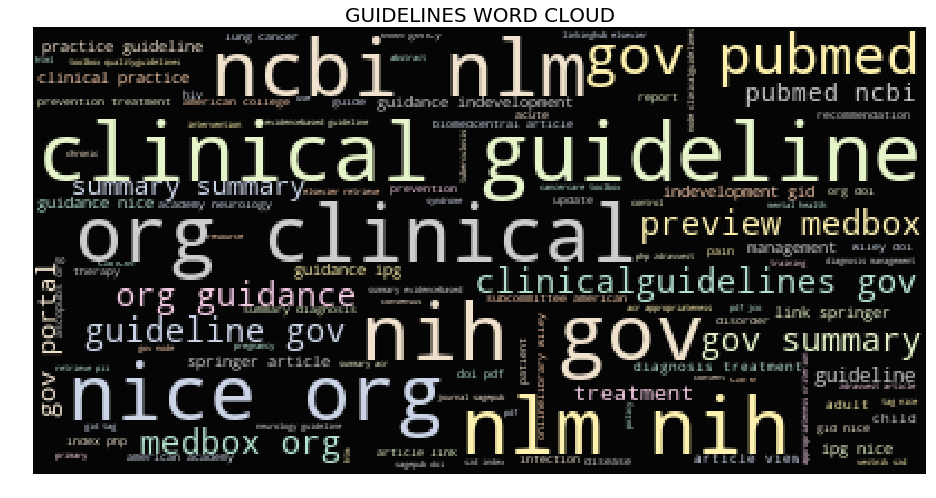

In [45]:
# The wordcloud of cat events
plt.figure(figsize=(16,13))
wc = WordCloud(background_color="black", max_words=10000,stopwords=STOPWORDS, max_font_size= 40)
wc.generate(" ".join(guidelines))
plt.title("GUIDELINES WORD CLOUD", fontsize=20)
# plt.imshow(wc.recolor( colormap= 'Pastel1_r' , random_state=17), alpha=0.98)
plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
plt.axis('off')

In [91]:
xtrain, xvalid, ytrain, yvalid = train_test_split(word_corpus[df['Tag'].notnull()], df.Tag[df['Tag'].notnull()],stratify=df.Tag[df['Tag'].notnull()], 
                                                  random_state=108, 
                                                  test_size=0.20)
xtest = word_corpus[df['Tag'].isnull()]
xtrain.shape,xvalid.shape,ytrain.shape,yvalid.shape,xtest.shape

((42757,), (10690,), (42757,), (10690,), (25787,))

In [104]:
## override the built in preprocessor and tokenizer since the tokenization is allready done
## ngram_range = (1,2)
tfv = TfidfVectorizer(preprocessor=lambda x: x, tokenizer=lambda x: x,min_df=10, max_features=None,ngram_range=(1, 3))
tfv.fit(list(xtrain) + list(xvalid) + list(xtest))
xtrain_tfv =  tfv.transform(xtrain) 
xvalid_tfv = tfv.transform(xvalid)
xtest_tfv =  tfv.transform(xtest) 

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=10,
        ngram_range=(1, 4), norm='l2',
        preprocessor=<function <lambda> at 0x0000000017D27268>,
        smooth_idf=True, stop_words=None, strip_accents=None,
        sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function <lambda> at 0x0000000017D278C8>, use_idf=True,
        vocabulary=None)

In [105]:
## xgboost -
import xgboost as xgb
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1,objective = 'multi:softprob')
clf.fit(xtrain_tfv.tocsc(), ytrain)




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=10, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)

In [106]:
## validation
predictions = clf.predict_proba(xvalid_tfv.tocsc())
predictions1 = clf.predict(xvalid_tfv.tocsc())

print(confusion_matrix(yvalid,predictions1))
log_loss(yvalid,predictions)
f1_score(yvalid,predictions1, labels=None, pos_label=1, average='weighted')

[[ 566    0    0    0    0    2    0    0    0]
 [   0  880    0    0    4   40    0    9    0]
 [   0    0  897    0    1    3    0    0    0]
 [   0    1    0  239    1   13    0   12    0]
 [   1    8    1    7 1389  169    5   18    0]
 [   1    2    2    1   62 3372   26   18    0]
 [   0    1    0    0    1   63  970    4    0]
 [   0    3    0   11    2   35    0 1490    0]
 [   0    0    0    0    0    0    0    0  360]]


C:\Users\rprasad\AppData\Local\Continuum1\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



0.20201105628879681

0.9505475280218155

In [107]:
## scoring

pred = clf.predict(xtest_tfv.tocsc())
unique, counts = np.unique(pred, return_counts=True)
np.asarray((unique, counts)).T
pred.shape
sub1 = pd.DataFrame({'Webpage_id':df['Webpage_id'][df['Tag'].isnull()],'Tag':pred})
sub1.to_csv("sub2.csv")

C:\Users\rprasad\AppData\Local\Continuum1\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



array([['clinicalTrials', 236],
       ['conferences', 1133],
       ['forum', 1120],
       ['guidelines', 248],
       ['news', 3212],
       ['others', 13491],
       ['profile', 2098],
       ['publication', 3949],
       ['thesis', 300]], dtype=object)

(25787,)

## Hyperparameter search

In [108]:
## hyperparameter grid
from sklearn.model_selection import RandomizedSearchCV



# Create the random grid
random_grid = {'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.1,0.01,0.001,0.2,0.15],
        'n_estimators': [500,700,1000,1500,2000]   }

print(random_grid)

xgb = XGBClassifier(objective='multi:softprob',silent=True, nthread=1)
xgb_random = RandomizedSearchCV(estimator = xgb, param_distributions = random_grid,n_iter=10,cv = 5,verbose=2, random_state=42,scoring='accuracy', n_jobs = -1)

{'min_child_weight': [1, 5, 10], 'gamma': [0.5, 1, 1.5, 2, 5], 'subsample': [0.6, 0.8, 1.0], 'colsample_bytree': [0.6, 0.8, 1.0], 'max_depth': [3, 4, 5], 'learning_rate': [0.1, 0.01, 0.001, 0.2, 0.15], 'n_estimators': [500, 700, 1000, 1500, 2000]}


In [109]:
# Fit the random search model
xgb_random.fit(xtrain_tfv.tocsc(), ytrain)



Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 107.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 190.6min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=1, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'min_child_weight': [1, 5, 10], 'gamma': [0.5, 1, 1.5, 2, 5], 'subsample': [0.6, 0.8, 1.0], 'colsample_bytree': [0.6, 0.8, 1.0], 'max_depth': [3, 4, 5], 'learning_rate': [0.1, 0.01, 0.001, 0.2, 0.15], 'n_estimators': [500, 700, 1000, 1500, 2000]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='accuracy', verbose=2)

NameError: name 'rf_random' is not defined

In [110]:
xgb_random.best_params_

{'colsample_bytree': 1.0,
 'gamma': 0.5,
 'learning_rate': 0.2,
 'max_depth': 5,
 'min_child_weight': 5,
 'n_estimators': 1500,
 'subsample': 0.8}

In [111]:
pred = xgb_random.predict(xtest_tfv.tocsc())
unique, counts = np.unique(pred, return_counts=True)
np.asarray((unique, counts)).T
pred.shape
sub1 = pd.DataFrame({'Webpage_id':df['Webpage_id'][df['Tag'].isnull()],'Tag':pred})
sub1.to_csv("sub2.csv")

C:\Users\rprasad\AppData\Local\Continuum1\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



array([['clinicalTrials', 242],
       ['conferences', 1309],
       ['forum', 1137],
       ['guidelines', 272],
       ['news', 4043],
       ['others', 12817],
       ['profile', 1844],
       ['publication', 3823],
       ['thesis', 300]], dtype=object)

(25787,)

In [112]:
## validation
#predictions = xgb_random.predict_proba(xvalid_tfv.tocsc())
predictions1 = xgb_random.predict(xvalid_tfv.tocsc())

print(confusion_matrix(yvalid,predictions1))
#log_loss(yvalid,predictions)
f1_score(yvalid,predictions1, labels=None, pos_label=1, average='weighted')

[[ 566    0    0    0    0    2    0    0    0]
 [   0  889    0    0    6   28    0   10    0]
 [   0    0  898    0    0    2    1    0    0]
 [   0    1    0  238    2   14    0   11    0]
 [   1    8    2    6 1456  108    5   12    0]
 [   0    6    2    1   66 3355   29   25    0]
 [   0    0    0    0    1   45  989    4    0]
 [   1    2    0   11    3   20    1 1503    0]
 [   0    0    0    0    0    0    0    0  360]]


C:\Users\rprasad\AppData\Local\Continuum1\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



0.9591374374789715